# **INVOICE PAYMENT DELAY PREDICTION MODEL**

# Install Dependencies

In [1]:
!pip install dython
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 25.0 MB/s 
     |████████████████████████████████| 950 kB 57.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Read and clean data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
import pandas as pd
from dython import nominal
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#read historical data
df = pd.read_excel('Historical_Records.xlsx')

# remove the outlier
df = df.drop(1)

# dropping unwanted columns
#cols_to_del = ['FY_Quarter','Quarter','Transaction Number','Transaction Date','Concat','Transaction Date_Date','Transaction Date_Mon','Transaction Date_Day','Due Date','Due_Date_Date','Due_Date_Month','Due_Date_Day','DPLC_Week']
cols_to_del = ['FY_Quarter','Quarter','Transaction Number','Concat','Transaction Date_Date','Transaction Date_Mon','Transaction Date_Day','Due_Date_Date','Due_Date_Month','Due_Date_Day','DPLC_Week']
df.drop(columns=cols_to_del,inplace=True)

In [3]:
import xgboost
import sklearn.metrics as sm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# Pre Processing

In [4]:
df

,Transaction Type_Mask,Transaction Date,Batch Source_Masked,Due Date,ABE,Credit Hold,PO Mandate,Web Invoicing,E Invoicing,DPLC,USD_AMT,Paid_15,buffer_days
0,trx_type-1,2017-03-21,batch_source-1,2017-05-05,No,No,No,No,Yes,459,166.006538,No,45
2,trx_type-4,2016-12-08,batch_source-3,2016-12-23,No,Yes,No,No,Yes,573,1783.498849,No,15
3,trx_type-3,2017-02-23,batch_source-2,2017-03-25,No,No,No,No,Yes,500,3559.064062,No,30
4,trx_type-3,2017-03-14,batch_source-2,2017-04-13,No,No,No,No,Yes,470,7661.386540,No,30
5,trx_type-2,2017-04-22,batch_source-2,2017-05-22,No,No,No,No,Yes,410,22487.566131,No,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34746,trx_type-18,2020-07-27,batch_source-4,2020-07-27,No,No,No,No,Yes,0,38253.603586,Yes,0
34747,trx_type-18,2020-07-30,batch_source-4,2020-07-30,No,No,No,No,Yes,0,797738.458666,Yes,0
34748,trx_type-18,2020-08-24,batch_source-4,2020-08-24,No,No,No,No,Yes,0,562623.965747,Yes,0
34749,trx_type-18,2020-08-31,batch_source-4,2020-08-31,No,Yes,No,No,Yes,0,11020.860515,Yes,0


In [ ]:
df.shape

(34750, 13)

In [ ]:
df.columns

Index(['Transaction Type_Mask', 'Transaction Date', 'Batch Source_Masked',
       'Due Date', 'ABE', 'Credit Hold', 'PO Mandate', 'Web Invoicing',
       'E Invoicing', 'DPLC', 'USD_AMT', 'Paid_15', 'buffer_days'],
      dtype='object')

In [ ]:
#Data Description
df.describe()

,DPLC,USD_AMT,buffer_days
count,34750.000000,3.475000e+04,34750.000000
mean,34.690734,4.524971e+04,27.559827
std,60.978740,3.697956e+05,8.413025
min,0.000000,2.813129e-04,0.000000
25%,0.000000,1.734293e+03,30.000000
50%,13.000000,6.469494e+03,30.000000
75%,42.000000,2.205117e+04,30.000000
max,979.000000,3.001514e+07,90.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34750 entries, 0 to 34750
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Transaction Type_Mask  34750 non-null  object        
 1   Transaction Date       34750 non-null  datetime64[ns]
 2   Batch Source_Masked    34750 non-null  object        
 3   Due Date               34750 non-null  datetime64[ns]
 4   ABE                    34750 non-null  object        
 5   Credit Hold            34750 non-null  object        
 6   PO Mandate             34750 non-null  object        
 7   Web Invoicing          34750 non-null  object        
 8   E Invoicing            34750 non-null  object        
 9   DPLC                   34750 non-null  int64         
 10  USD_AMT                34750 non-null  float64       
 11  Paid_15                34750 non-null  object        
 12  buffer_days            34750 non-null  int64         
dtypes

There is no missing data in any of the columns, so no further imputting is required

In [ ]:
df.isnull().sum()

Transaction Type_Mask    0
Transaction Date         0
Batch Source_Masked      0
Due Date                 0
ABE                      0
Credit Hold              0
PO Mandate               0
Web Invoicing            0
E Invoicing              0
DPLC                     0
USD_AMT                  0
Paid_15                  0
buffer_days              0
dtype: int64

Checking for unique values in each column

In [ ]:
for cols in df.columns:   
    print(f"{cols} - {df[f'{cols}'].nunique()}")

Transaction Type_Mask - 19
Transaction Date - 857
Batch Source_Masked - 7
Due Date - 990
ABE - 2
Credit Hold - 2
PO Mandate - 2
Web Invoicing - 2
E Invoicing - 2
DPLC - 475
USD_AMT - 30347
Paid_15 - 2
buffer_days - 12


In [ ]:
#Frequency Table
count = df.nunique().to_frame(name = 'Counts')
count

,Counts
Transaction Type_Mask,19
Transaction Date,857
Batch Source_Masked,7
Due Date,990
ABE,2
Credit Hold,2
PO Mandate,2
Web Invoicing,2
E Invoicing,2
DPLC,475


Outliers Analysis

In [ ]:
features = ['DPLC', 'USD_AMT', 'buffer_days']

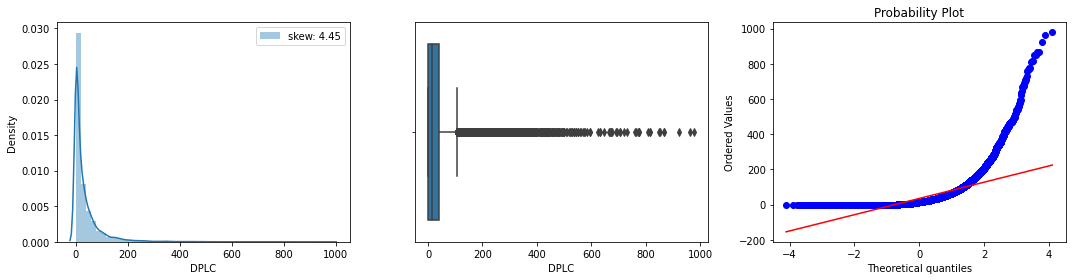

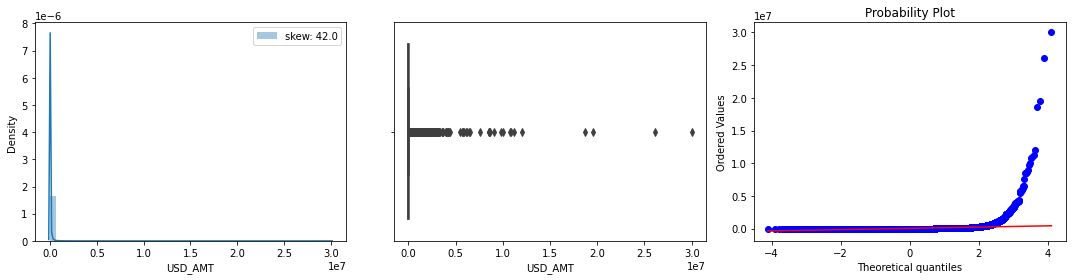

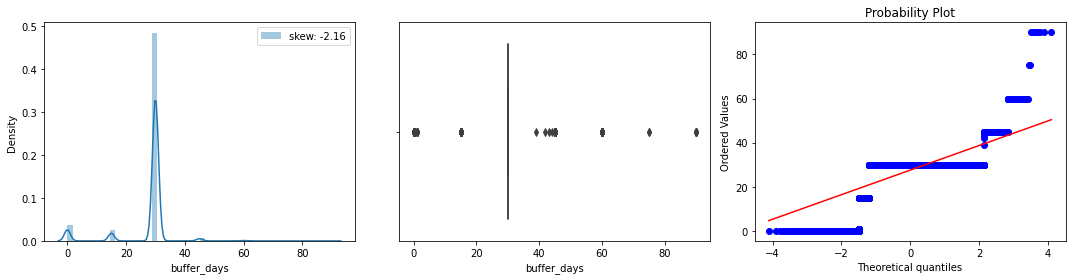

In [ ]:
for col in features:
    plt.figure(figsize=(15,4))
    plt.subplot(131)
    sns.distplot(df[col], label="skew: "+str(np.round(df[col].skew(),2)))
    plt.legend()
    plt.subplot(132)
    sns.boxplot(df[col])
    plt.subplot(133)
    stats.probplot(df[col],plot=plt)
    plt.tight_layout()
    plt.show()

In [ ]:
df

,Transaction Type_Mask,Transaction Date,Batch Source_Masked,Due Date,ABE,Credit Hold,PO Mandate,Web Invoicing,E Invoicing,DPLC,USD_AMT,Paid_15,buffer_days
0,trx_type-1,2017-03-21,batch_source-1,2017-05-05,No,No,No,No,Yes,459,166.006538,No,45
2,trx_type-4,2016-12-08,batch_source-3,2016-12-23,No,Yes,No,No,Yes,573,1783.498849,No,15
3,trx_type-3,2017-02-23,batch_source-2,2017-03-25,No,No,No,No,Yes,500,3559.064062,No,30
4,trx_type-3,2017-03-14,batch_source-2,2017-04-13,No,No,No,No,Yes,470,7661.386540,No,30
5,trx_type-2,2017-04-22,batch_source-2,2017-05-22,No,No,No,No,Yes,410,22487.566131,No,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34746,trx_type-18,2020-07-27,batch_source-4,2020-07-27,No,No,No,No,Yes,0,38253.603586,Yes,0
34747,trx_type-18,2020-07-30,batch_source-4,2020-07-30,No,No,No,No,Yes,0,797738.458666,Yes,0
34748,trx_type-18,2020-08-24,batch_source-4,2020-08-24,No,No,No,No,Yes,0,562623.965747,Yes,0
34749,trx_type-18,2020-08-31,batch_source-4,2020-08-31,No,Yes,No,No,Yes,0,11020.860515,Yes,0


Finding Correlation

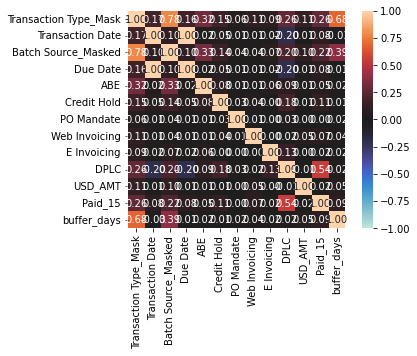

{'corr':                        Transaction Type_Mask  Transaction Date  \
 Transaction Type_Mask               1.000000          0.169840   
 Transaction Date                    0.169840          1.000000   
 Batch Source_Masked                 0.775545          0.098458   
 Due Date                            0.162445          0.999401   
 ABE                                 0.320101          0.023601   
 Credit Hold                         0.154006          0.051731   
 PO Mandate                          0.055661          0.010972   
 Web Invoicing                       0.107537          0.012049   
 E Invoicing                         0.086785          0.016525   
 DPLC                                0.261234         -0.196532   
 USD_AMT                             0.112367          0.006444   
 Paid_15                             0.261885          0.082095   
 buffer_days                         0.681847         -0.027157   
 
                        Batch Source_Masked  Due Dat

In [ ]:
#dython analysis
nominal.associations(df,nominal_columns=['ABE','Credit Hold','PO Mandate','Web Invoicing','E Invoicing','Transaction Type_Mask','Batch Source_Masked','Paid_15'])

Bar Plot representing the Frequency Counts

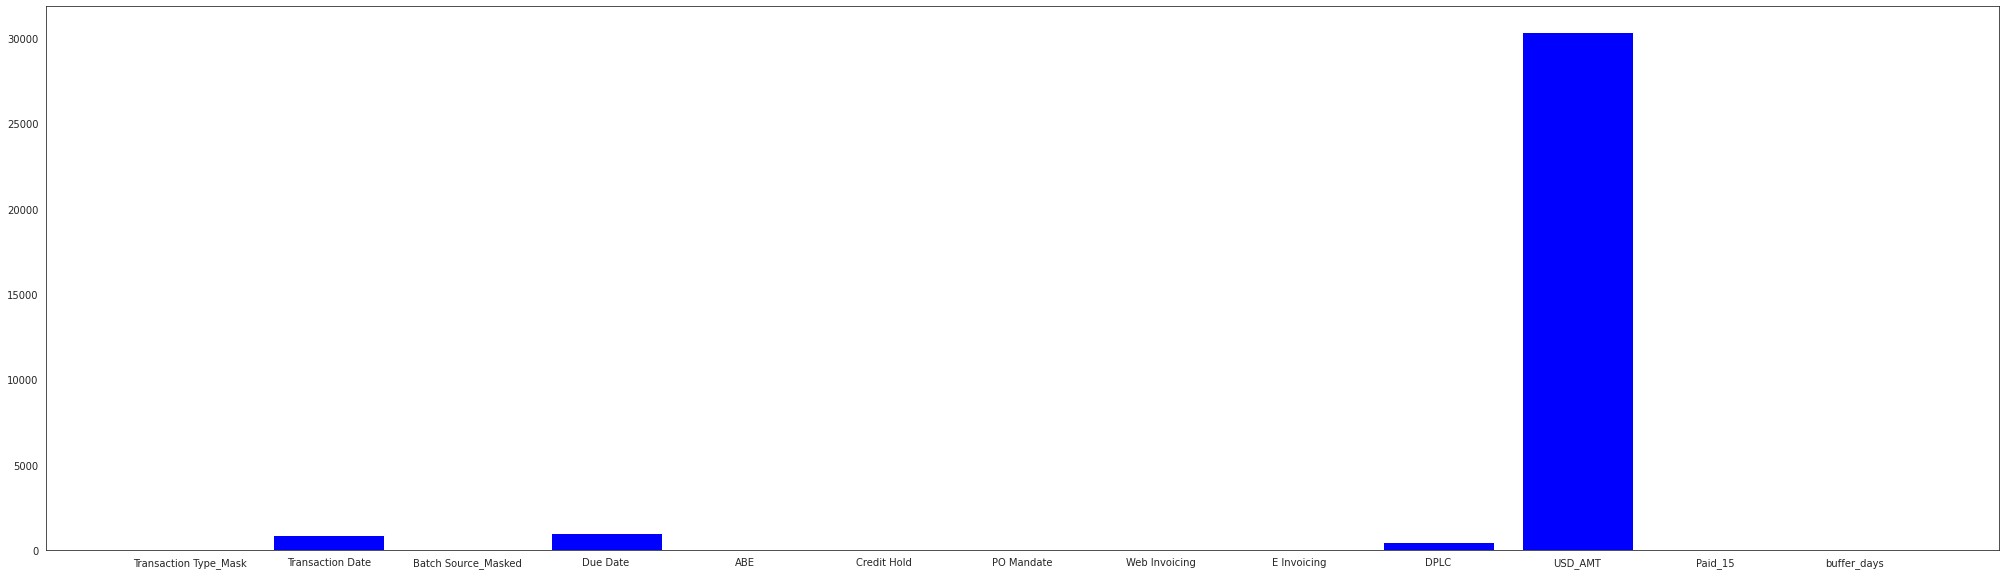

In [ ]:
#plt.style.use('dark_background')
sns.set_style("white")

x_val = count.index
y_val = count.values.reshape(count.shape[0])
plt.figure(figsize = (35,10))
plt.bar(x_val,y_val,color='blue')
plt.show()

Mode - Most Frequently occuring element

In [ ]:
df[['Transaction Type_Mask','Transaction Date','USD_AMT','Paid_15']].agg(pd.Series.mode)

,Transaction Type_Mask,Transaction Date,USD_AMT,Paid_15
0,trx_type-2,2019-04-05,132.783459,Yes


Mean and Standard Deviation - interval level variables (USD_AMT)

In [ ]:
df['USD_AMT'].agg(['mean','std']).to_frame()

,USD_AMT
mean,45249.712244
std,369795.649551


Checking for Null values

In [ ]:
null_vals = df.isnull().sum().to_frame(name = 'NULL_COUNTS')
null_vals = null_vals[null_vals['NULL_COUNTS']>0]
null_features = null_vals.index
null_vals

,NULL_COUNTS


New column - Delay (Transaction Date - Due Date)

In [5]:
#New Column Delay
df['delay']=(df['Due Date']-df['Transaction Date']).dt.days

In [6]:
df

,Transaction Type_Mask,Transaction Date,Batch Source_Masked,Due Date,ABE,Credit Hold,PO Mandate,Web Invoicing,E Invoicing,DPLC,USD_AMT,Paid_15,buffer_days,delay
0,trx_type-1,2017-03-21,batch_source-1,2017-05-05,No,No,No,No,Yes,459,166.006538,No,45,45
2,trx_type-4,2016-12-08,batch_source-3,2016-12-23,No,Yes,No,No,Yes,573,1783.498849,No,15,15
3,trx_type-3,2017-02-23,batch_source-2,2017-03-25,No,No,No,No,Yes,500,3559.064062,No,30,30
4,trx_type-3,2017-03-14,batch_source-2,2017-04-13,No,No,No,No,Yes,470,7661.386540,No,30,30
5,trx_type-2,2017-04-22,batch_source-2,2017-05-22,No,No,No,No,Yes,410,22487.566131,No,30,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34746,trx_type-18,2020-07-27,batch_source-4,2020-07-27,No,No,No,No,Yes,0,38253.603586,Yes,0,0
34747,trx_type-18,2020-07-30,batch_source-4,2020-07-30,No,No,No,No,Yes,0,797738.458666,Yes,0,0
34748,trx_type-18,2020-08-24,batch_source-4,2020-08-24,No,No,No,No,Yes,0,562623.965747,Yes,0,0
34749,trx_type-18,2020-08-31,batch_source-4,2020-08-31,No,Yes,No,No,Yes,0,11020.860515,Yes,0,0


# Exploratory Data Analysis

In [ ]:
count  = df.nunique().to_frame(name = 'Counts')
count

,Counts
Transaction Type_Mask,19
Transaction Date,857
Batch Source_Masked,7
Due Date,990
ABE,2
Credit Hold,2
PO Mandate,2
Web Invoicing,2
E Invoicing,2
DPLC,475


In [ ]:
df["Transaction Type_Mask"].value_counts()

trx_type-2     14275
trx_type-4      6216
trx_type-3      4543
trx_type-9      3457
trx_type-8      2102
trx_type-14     1148
trx_type-15      764
trx_type-10      585
trx_type-16      546
trx_type-12      421
trx_type-5       329
trx_type-13      206
trx_type-17       48
trx_type-18       44
trx_type-19       39
trx_type-1        15
trx_type-6        10
trx_type-11        1
trx_type-7         1
Name: Transaction Type_Mask, dtype: int64

<AxesSubplot:xlabel='Transaction Type_Mask', ylabel='count'>

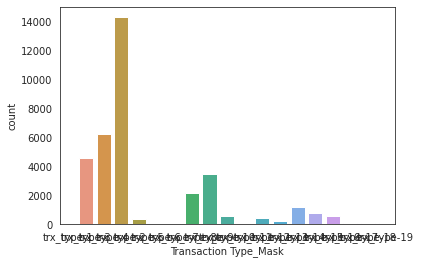

In [ ]:
sns.countplot(df["Transaction Type_Mask"])

In [ ]:
df["Transaction Date"].min()

Timestamp('2016-05-31 00:00:00')

In [ ]:
df["Transaction Date"].max()

Timestamp('2020-08-31 00:00:00')

In [ ]:
transact_month = df["Transaction Date"].dt.month
transact_month.value_counts()

5     6270
4     4111
8     3538
2     3009
11    2917
6     2643
1     2471
7     2413
3     2145
10    1978
12    1653
9     1603
Name: Transaction Date, dtype: int64

<AxesSubplot:xlabel='Transaction Date', ylabel='count'>

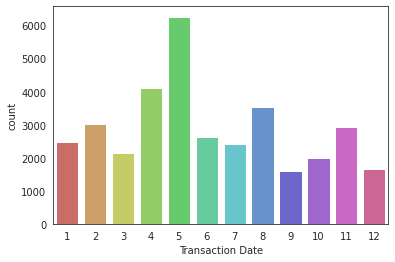

In [ ]:
sns.countplot(x=transact_month, palette="hls")

May is the month where the companies completed their maximum transations.

In [ ]:
df['USD_AMT'].describe().apply(lambda x: format(x,'f'))

count       34751.000000
mean        45248.662564
std        369790.380484
min             0.000281
25%          1734.405000
50%          6470.068919
75%         22050.861721
max      30015142.698223
Name: USD_AMT, dtype: object

The amount that is yet to be paid for that invoice

In [ ]:
open_amount_bins = pd.qcut(df['USD_AMT'],q=10)
open_amount_bins.value_counts()

(-0.000719, 373.669]        3476
(373.669, 1073.45]          3475
(1073.45, 2527.341]         3475
(2527.341, 3947.47]         3475
(3947.47, 6470.069]         3475
(6470.069, 10492.861]       3475
(10492.861, 16983.975]      3475
(16983.975, 28843.365]      3475
(28843.365, 62029.58]       3475
(62029.58, 30015142.698]    3475
Name: USD_AMT, dtype: int64

HISTOGRAM

Automatically binning the amount using pd.qcut.

In [ ]:
amount_bins = [0,5000,10000,50000,100000,1100000]
amount_bins = [0,500,1000,5000,10000,110000]
new_open_amount_bin = pd.cut(df['USD_AMT'], bins = amount_bins)

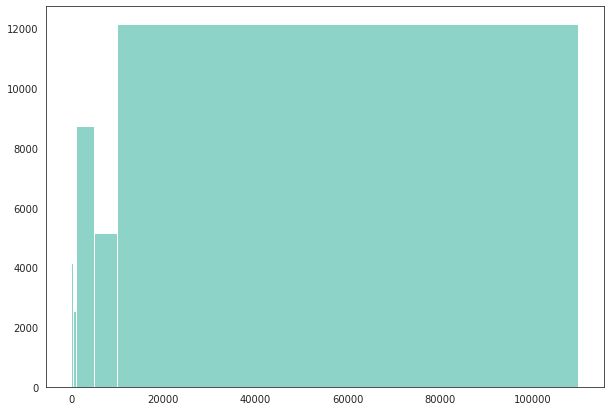

In [ ]:
# Creating dataset
a = df["USD_AMT"]
 
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,500,1000,5000,10000,110000])
 
# Show plot
plt.show()

In [ ]:
new_open_amount_bin

0               (0.0, 500.0]
2          (5000.0, 10000.0]
3           (1000.0, 5000.0]
4           (1000.0, 5000.0]
5          (5000.0, 10000.0]
                ...         
34747    (10000.0, 110000.0]
34748                    NaN
34749                    NaN
34750    (10000.0, 110000.0]
34751        (500.0, 1000.0]
Name: USD_AMT, Length: 34751, dtype: category
Categories (5, interval[int64, right]): [(0, 500] < (500, 1000] < (1000, 5000] < (5000, 10000] <
                                         (10000, 110000]]

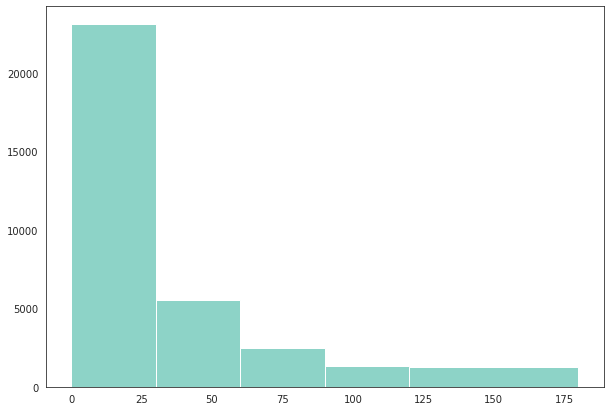

In [ ]:
# Creating dataset
a = df["DPLC"]
 
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,30,60,90,120,180])
 
# Show plot
plt.show()

<AxesSubplot:xlabel='USD_AMT', ylabel='count'>

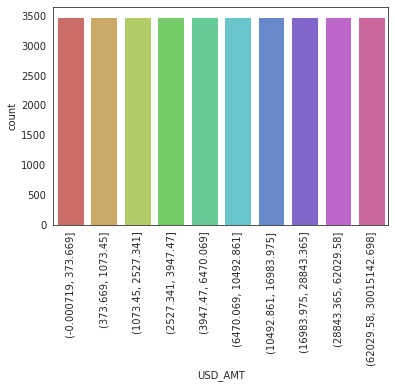

In [ ]:
plt.xticks(fontsize=10, rotation=90)
sns.countplot(x=open_amount_bins, palette="hls")

In [ ]:
df.ABE.value_counts()

No     33940
Yes      811
Name: ABE, dtype: int64

In [ ]:
df["Credit Hold"].value_counts()

No     32476
Yes     2275
Name: Credit Hold, dtype: int64

In [ ]:
df["PO Mandate"].value_counts()

No     34568
Yes      183
Name: PO Mandate, dtype: int64

In [ ]:
df["Web Invoicing"].value_counts()

No     33931
Yes      820
Name: Web Invoicing, dtype: int64

In [ ]:
df["E Invoicing"].value_counts()

Yes    34668
No        83
Name: E Invoicing, dtype: int64

Relation between USD_AMT and delay

In [ ]:
delay_bins = [0,15,30,45,60,90,300]
delay_bucket = pd.cut(df['delay'], bins = delay_bins)
pd.crosstab(index = new_open_amount_bin, columns = delay_bucket)

delay,"(0, 15]","(15, 30]","(30, 45]","(45, 60]","(60, 90]"
USD_AMT,,,,,
"(0, 500]",173,2467,73,0,0
"(500, 1000]",114,2099,46,0,0
"(1000, 5000]",467,7622,129,5,2
"(5000, 10000]",334,4701,53,14,0
"(10000, 110000]",486,11432,133,27,4


<AxesSubplot:xlabel='USD_AMT', ylabel='count'>

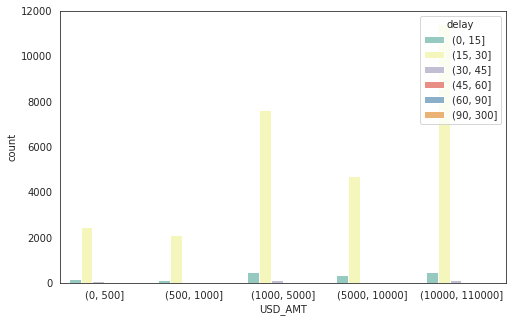

In [ ]:
plt.figure(figsize=(8,5))
plt.xlabel("Amount bin")
sns.countplot(x = new_open_amount_bin, hue=delay_bucket)

As we can see from the graph for each bucket the amount was returned in 0-15 delay days.

In [ ]:
df.corr()

,DPLC,USD_AMT,buffer_days,delay
DPLC,1.000000,-0.009164,0.024833,0.024833
USD_AMT,-0.009164,1.000000,0.050093,0.050093
buffer_days,0.024833,0.050093,1.000000,1.000000
delay,0.024833,0.050093,1.000000,1.000000


BOX PLOT

Text(0.5, 1.0, 'Days delayed')

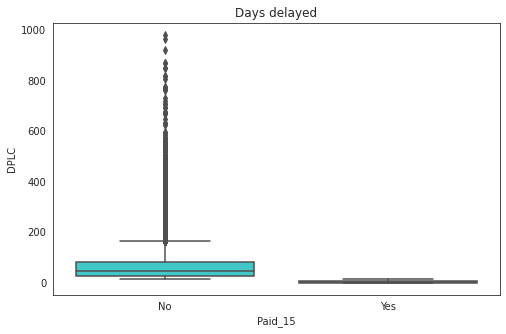

In [ ]:
plt.figure(figsize=(8,5))
sns.set_style("white")
sns.boxplot(x='Paid_15',y='DPLC',data=df, palette='rainbow')
plt.title("Days delayed")

BOXEN PLOT

Text(0.5, 1.0, 'Days delayed')

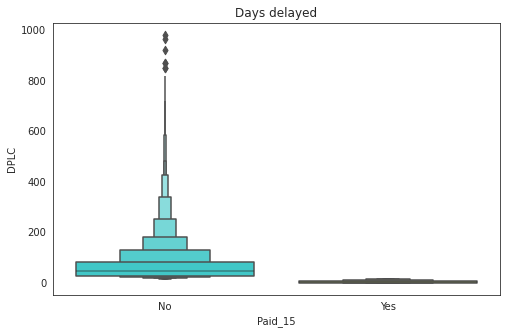

In [ ]:
plt.figure(figsize=(8,5))
sns.set_style("white")
sns.boxenplot(x='Paid_15',y='DPLC',data=df, palette='rainbow')
plt.title("Days delayed")

COUNT PLOT

Text(0.5, 1.0, 'Count of ABE')

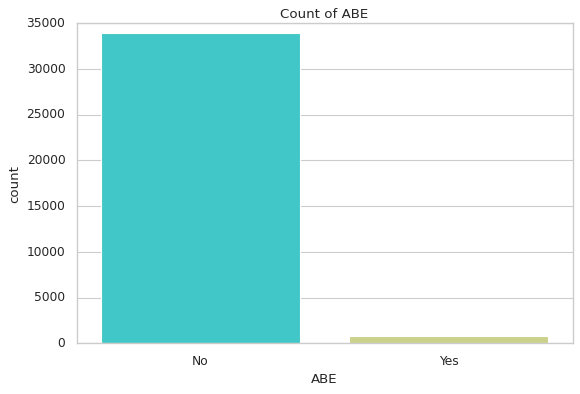

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='ABE',data=df, palette='rainbow')
plt.title("Count of ABE")

Text(0.5, 1.0, 'Count of Credit Hold')

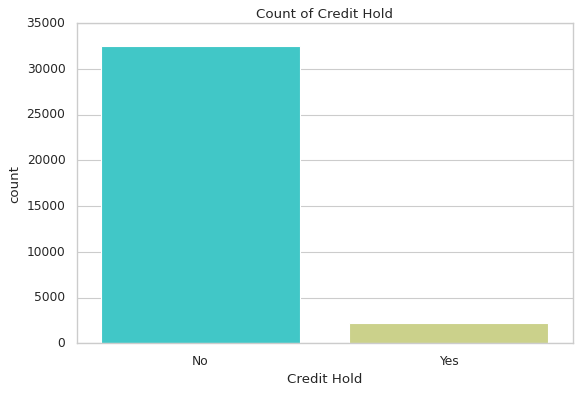

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Credit Hold',data=df, palette='rainbow')
plt.title("Count of Credit Hold")

Text(0.5, 1.0, 'Count of PO Mandate')

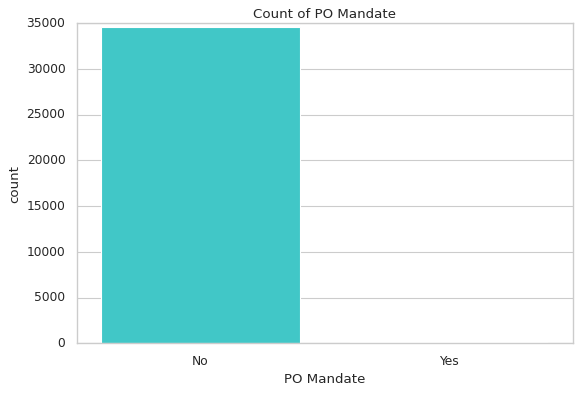

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='PO Mandate',data=df, palette='rainbow')
plt.title("Count of PO Mandate")

Text(0.5, 1.0, 'Count of Web Invoicing')

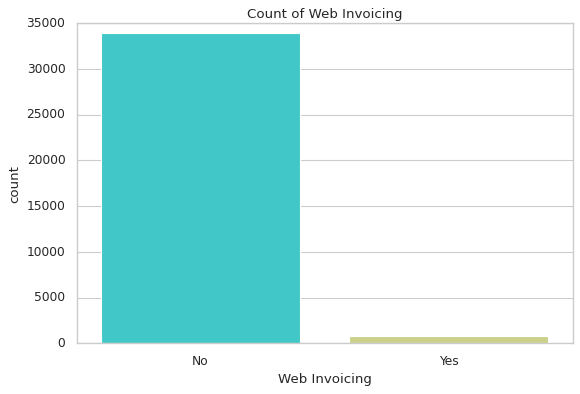

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Web Invoicing',data=df, palette='rainbow')
plt.title("Count of Web Invoicing")

Text(0.5, 1.0, 'Count of E-Invoicing')

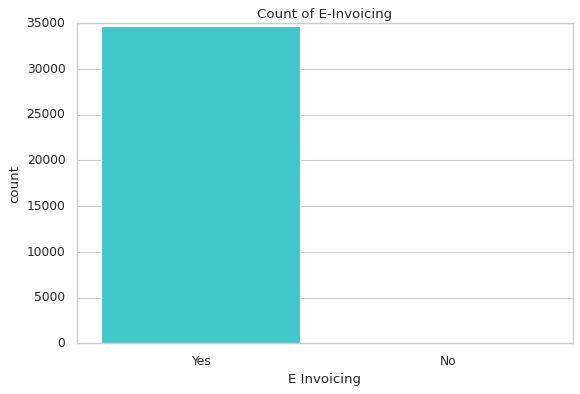

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='E Invoicing',data=df, palette='rainbow')
plt.title("Count of E-Invoicing")

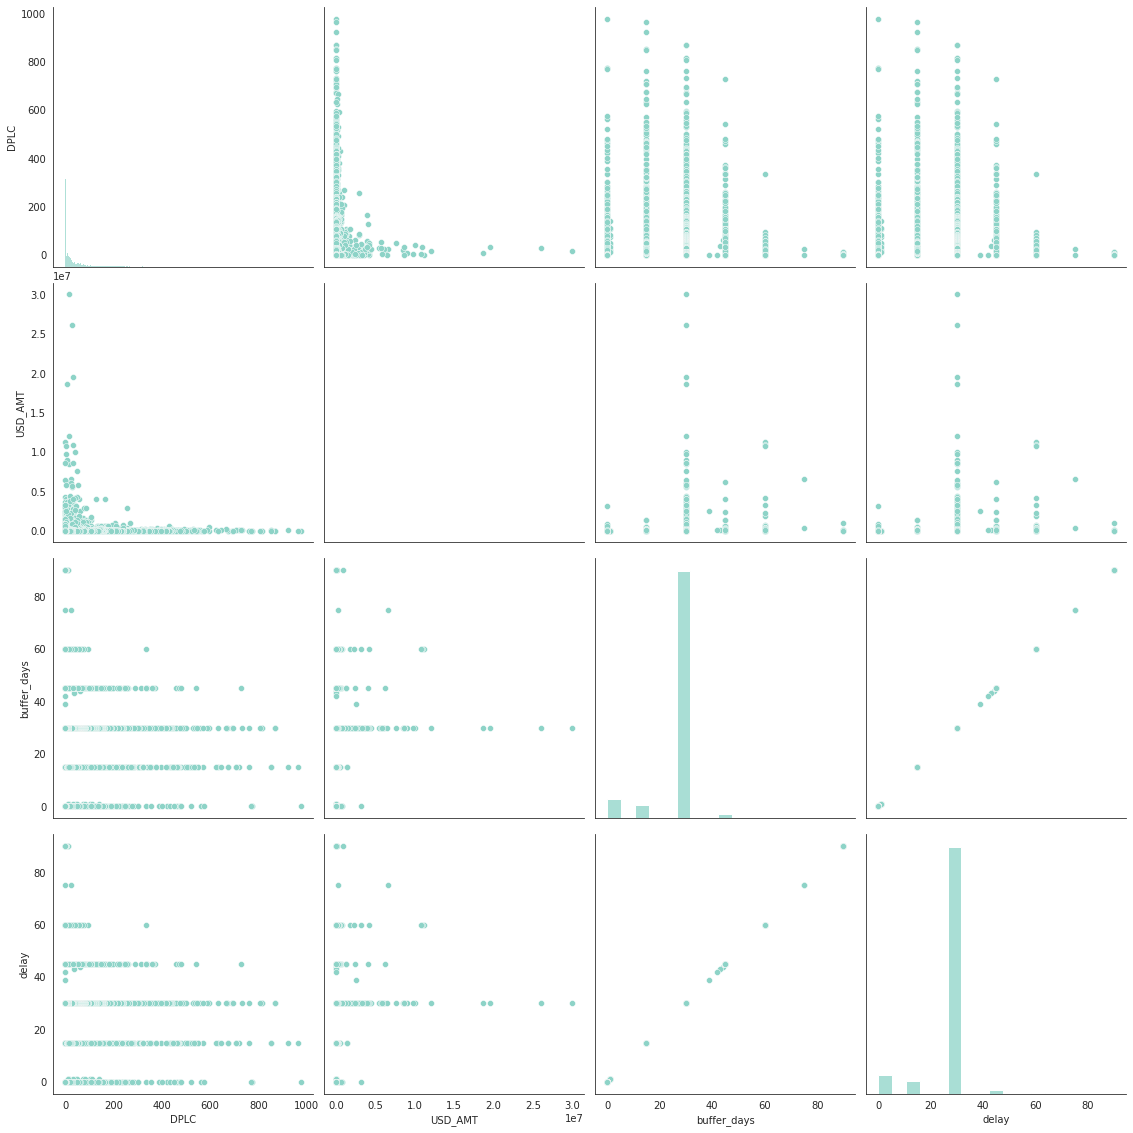

In [ ]:
sns.pairplot(df, height=4)

In [ ]:
df

,Transaction Type_Mask,Transaction Date,Batch Source_Masked,Due Date,ABE,Credit Hold,PO Mandate,Web Invoicing,E Invoicing,DPLC,USD_AMT,Paid_15,buffer_days,delay
0,trx_type-1,2017-03-21,batch_source-1,2017-05-05,No,No,No,No,Yes,459,166.006538,No,45,45
2,trx_type-4,2016-12-08,batch_source-3,2016-12-23,No,Yes,No,No,Yes,573,1783.498849,No,15,15
3,trx_type-3,2017-02-23,batch_source-2,2017-03-25,No,No,No,No,Yes,500,3559.064062,No,30,30
4,trx_type-3,2017-03-14,batch_source-2,2017-04-13,No,No,No,No,Yes,470,7661.386540,No,30,30
5,trx_type-2,2017-04-22,batch_source-2,2017-05-22,No,No,No,No,Yes,410,22487.566131,No,30,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34746,trx_type-18,2020-07-27,batch_source-4,2020-07-27,No,No,No,No,Yes,0,38253.603586,Yes,0,0
34747,trx_type-18,2020-07-30,batch_source-4,2020-07-30,No,No,No,No,Yes,0,797738.458666,Yes,0,0
34748,trx_type-18,2020-08-24,batch_source-4,2020-08-24,No,No,No,No,Yes,0,562623.965747,Yes,0,0
34749,trx_type-18,2020-08-31,batch_source-4,2020-08-31,No,Yes,No,No,Yes,0,11020.860515,Yes,0,0


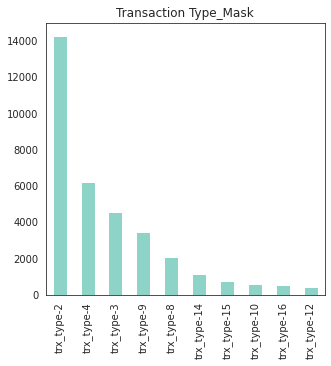

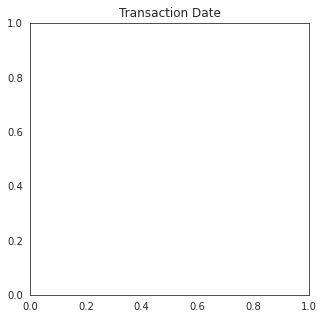

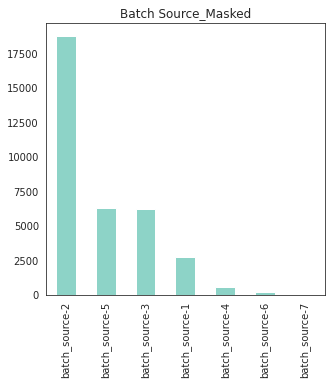

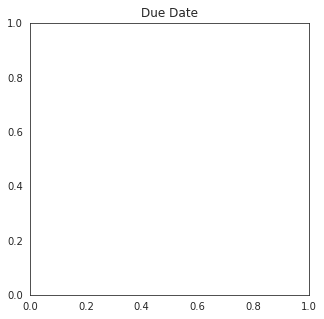

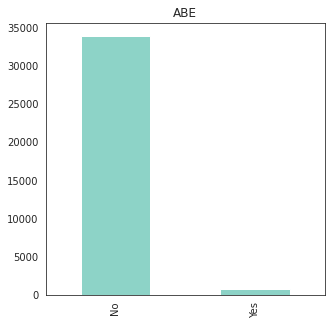

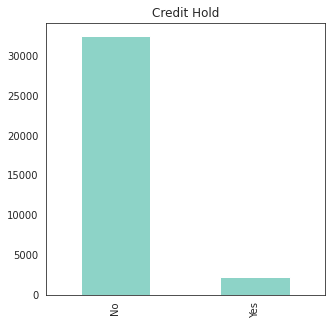

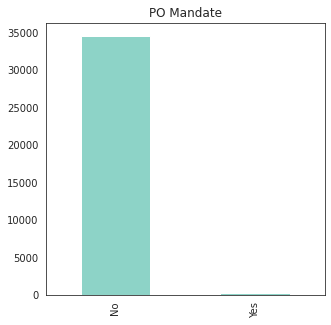

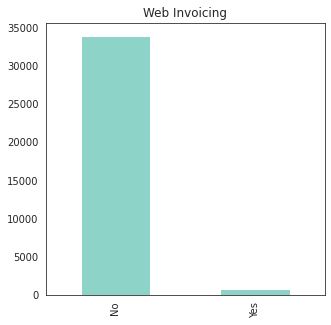

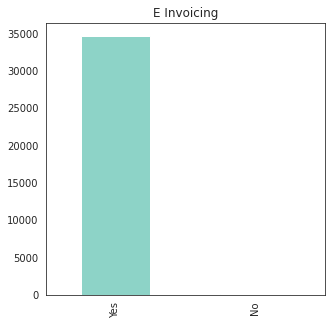

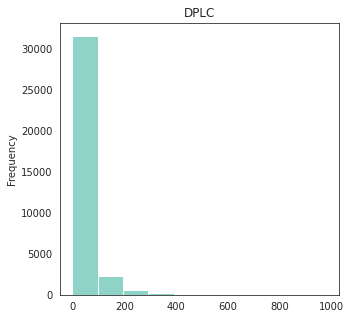

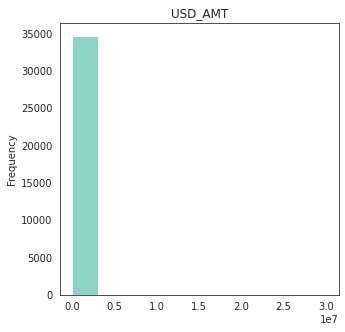

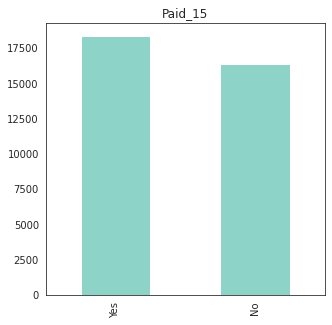

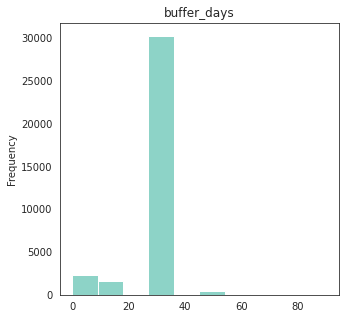

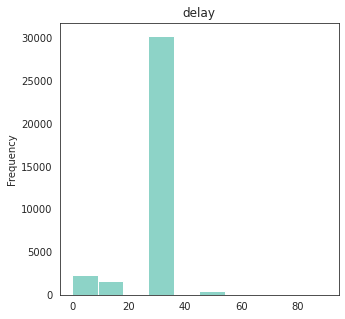

In [ ]:
from pandas.api.types import is_string_dtype, is_numeric_dtype
for column in df:
  plt.figure(column, figsize = (5,5))
  plt.title(column)
  if is_numeric_dtype(df[column]):
    df[column].plot(kind = 'hist')
  elif is_string_dtype(df[column]):
    df[column].value_counts()[:10].plot(kind = 'bar')

# Feature Engineering

In [7]:
df["Transaction Date_day"] = df["Transaction Date"].dt.day
df["Transaction Date_month"] = df["Transaction Date"].dt.month

df["Due Date_day"] = df["Due Date"].dt.day
df["Due Date_month"] = df["Due Date"].dt.month

In [8]:
df

,Transaction Type_Mask,Transaction Date,Batch Source_Masked,Due Date,ABE,Credit Hold,PO Mandate,Web Invoicing,E Invoicing,DPLC,USD_AMT,Paid_15,buffer_days,delay,Transaction Date_day,Transaction Date_month,Due Date_day,Due Date_month
0,trx_type-1,2017-03-21,batch_source-1,2017-05-05,No,No,No,No,Yes,459,166.006538,No,45,45,21,3,5,5
2,trx_type-4,2016-12-08,batch_source-3,2016-12-23,No,Yes,No,No,Yes,573,1783.498849,No,15,15,8,12,23,12
3,trx_type-3,2017-02-23,batch_source-2,2017-03-25,No,No,No,No,Yes,500,3559.064062,No,30,30,23,2,25,3
4,trx_type-3,2017-03-14,batch_source-2,2017-04-13,No,No,No,No,Yes,470,7661.386540,No,30,30,14,3,13,4
5,trx_type-2,2017-04-22,batch_source-2,2017-05-22,No,No,No,No,Yes,410,22487.566131,No,30,30,22,4,22,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34746,trx_type-18,2020-07-27,batch_source-4,2020-07-27,No,No,No,No,Yes,0,38253.603586,Yes,0,0,27,7,27,7
34747,trx_type-18,2020-07-30,batch_source-4,2020-07-30,No,No,No,No,Yes,0,797738.458666,Yes,0,0,30,7,30,7
34748,trx_type-18,2020-08-24,batch_source-4,2020-08-24,No,No,No,No,Yes,0,562623.965747,Yes,0,0,24,8,24,8
34749,trx_type-18,2020-08-31,batch_source-4,2020-08-31,No,Yes,No,No,Yes,0,11020.860515,Yes,0,0,31,8,31,8


In [9]:
def bucketization(x):
    if x<0:
        return('(< 0) Days')
    if x in range(0,16):
        return('(0-15) Days')
    elif x in range(16,31):
        return('(16-30) Days')
    elif x in range(31,45):
        return('(31-45) Days')
    elif x in range(45,60):
        return('(45-60) Days')
    else:
        return('(> 60) Days')

In [10]:
import gc

In [11]:
gc.collect()
df = df.reset_index(drop=True)
df['DELAY BUCKET(DAYS)']= pd.Series([bucketization(x=df['delay'][i])  for i in range(len(df))])
bucket_mapper = {'(< 0) Days':0,'(0-15) Days':1,'(16-30) Days':2,'(31-45) Days':4,'(45-60) Days':5,'(> 60) Days':6}
df['delay_bucket_id'] = df['DELAY BUCKET(DAYS)'].map(bucket_mapper)
df.columns

Index(['Transaction Type_Mask', 'Transaction Date', 'Batch Source_Masked',
       'Due Date', 'ABE', 'Credit Hold', 'PO Mandate', 'Web Invoicing',
       'E Invoicing', 'DPLC', 'USD_AMT', 'Paid_15', 'buffer_days', 'delay',
       'Transaction Date_day', 'Transaction Date_month', 'Due Date_day',
       'Due Date_month', 'DELAY BUCKET(DAYS)', 'delay_bucket_id'],
      dtype='object')

In [12]:
df

,Transaction Type_Mask,Transaction Date,Batch Source_Masked,Due Date,ABE,Credit Hold,PO Mandate,Web Invoicing,E Invoicing,DPLC,USD_AMT,Paid_15,buffer_days,delay,Transaction Date_day,Transaction Date_month,Due Date_day,Due Date_month,DELAY BUCKET(DAYS),delay_bucket_id
0,trx_type-1,2017-03-21,batch_source-1,2017-05-05,No,No,No,No,Yes,459,166.006538,No,45,45,21,3,5,5,(45-60) Days,5
1,trx_type-4,2016-12-08,batch_source-3,2016-12-23,No,Yes,No,No,Yes,573,1783.498849,No,15,15,8,12,23,12,(0-15) Days,1
2,trx_type-3,2017-02-23,batch_source-2,2017-03-25,No,No,No,No,Yes,500,3559.064062,No,30,30,23,2,25,3,(16-30) Days,2
3,trx_type-3,2017-03-14,batch_source-2,2017-04-13,No,No,No,No,Yes,470,7661.386540,No,30,30,14,3,13,4,(16-30) Days,2
4,trx_type-2,2017-04-22,batch_source-2,2017-05-22,No,No,No,No,Yes,410,22487.566131,No,30,30,22,4,22,5,(16-30) Days,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34745,trx_type-18,2020-07-27,batch_source-4,2020-07-27,No,No,No,No,Yes,0,38253.603586,Yes,0,0,27,7,27,7,(0-15) Days,1
34746,trx_type-18,2020-07-30,batch_source-4,2020-07-30,No,No,No,No,Yes,0,797738.458666,Yes,0,0,30,7,30,7,(0-15) Days,1
34747,trx_type-18,2020-08-24,batch_source-4,2020-08-24,No,No,No,No,Yes,0,562623.965747,Yes,0,0,24,8,24,8,(0-15) Days,1
34748,trx_type-18,2020-08-31,batch_source-4,2020-08-31,No,Yes,No,No,Yes,0,11020.860515,Yes,0,0,31,8,31,8,(0-15) Days,1


## Feature Selection

<AxesSubplot:>

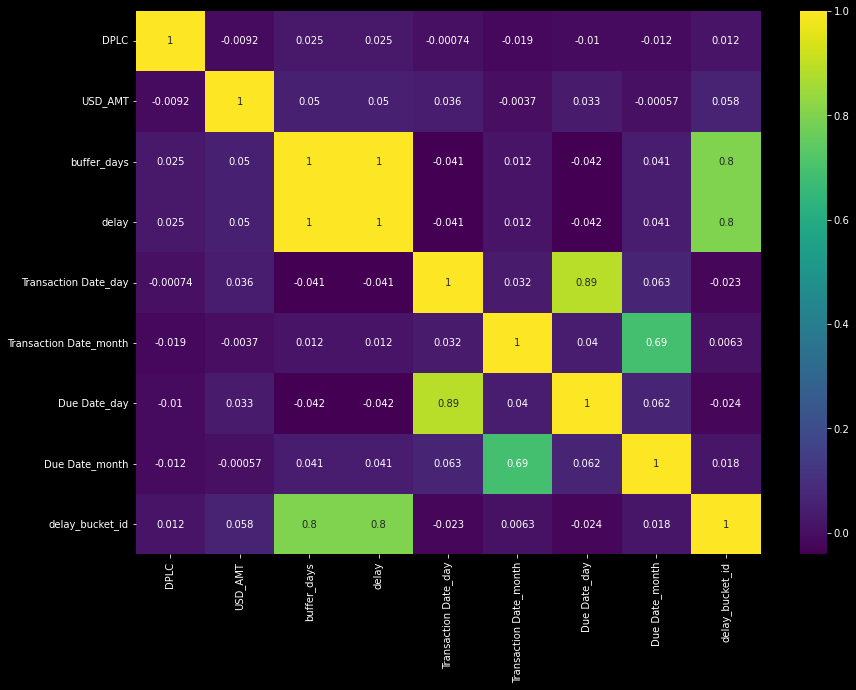

In [ ]:
plt.figure(figsize=(14,10))
cor = df.corr()
sns.heatmap(cor,cmap = 'viridis',annot=True)

In [13]:
cols_to_del1 = ['Transaction Date','Due Date']
df.drop(columns=cols_to_del1,inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34750 entries, 0 to 34749
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Transaction Type_Mask   34750 non-null  object 
 1   Batch Source_Masked     34750 non-null  object 
 2   ABE                     34750 non-null  object 
 3   Credit Hold             34750 non-null  object 
 4   PO Mandate              34750 non-null  object 
 5   Web Invoicing           34750 non-null  object 
 6   E Invoicing             34750 non-null  object 
 7   DPLC                    34750 non-null  int64  
 8   USD_AMT                 34750 non-null  float64
 9   Paid_15                 34750 non-null  object 
 10  buffer_days             34750 non-null  int64  
 11  delay                   34750 non-null  int64  
 12  Transaction Date_day    34750 non-null  int64  
 13  Transaction Date_month  34750 non-null  int64  
 14  Due Date_day            34750 non-null

# Setting Label Column & Label Encoding

In [15]:
sample_df = df.copy()
Y_Paid_15 = sample_df[['Paid_15']]
X_Paid = sample_df.drop(columns=['Paid_15','DPLC'])
Y_Paid_15.describe()

,Paid_15
count,34750
unique,2
top,Yes
freq,18375


In [16]:
# Import label encoder
from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column Paid 15.
Y_Paid_15['Paid_15'] = label_encoder.fit_transform(Y_Paid_15['Paid_15'])
Y_Paid_15['Paid_15'].unique()

array([0, 1])

# Separating label column

In [17]:
sample_dplc_df = df[df['Paid_15']=='No'].copy()
Y_DPLC = sample_dplc_df['DPLC']
def get_DPLC(x):
    days = x//7
    if days > 10: return 10
    return days
Y_DPLC = Y_DPLC.apply(lambda x:get_DPLC(x))
X_DPLC = sample_dplc_df.drop(columns=['DPLC','Paid_15'])
Y_DPLC.unique()

array([10,  9,  6,  8,  7,  4,  5,  3,  2])

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'),
     make_column_selector(dtype_include='object')),
    remainder='passthrough')

In [19]:
X_Paid

,Transaction Type_Mask,Batch Source_Masked,ABE,Credit Hold,PO Mandate,Web Invoicing,E Invoicing,USD_AMT,buffer_days,delay,Transaction Date_day,Transaction Date_month,Due Date_day,Due Date_month,DELAY BUCKET(DAYS),delay_bucket_id
0,trx_type-1,batch_source-1,No,No,No,No,Yes,166.006538,45,45,21,3,5,5,(45-60) Days,5
1,trx_type-4,batch_source-3,No,Yes,No,No,Yes,1783.498849,15,15,8,12,23,12,(0-15) Days,1
2,trx_type-3,batch_source-2,No,No,No,No,Yes,3559.064062,30,30,23,2,25,3,(16-30) Days,2
3,trx_type-3,batch_source-2,No,No,No,No,Yes,7661.386540,30,30,14,3,13,4,(16-30) Days,2
4,trx_type-2,batch_source-2,No,No,No,No,Yes,22487.566131,30,30,22,4,22,5,(16-30) Days,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34745,trx_type-18,batch_source-4,No,No,No,No,Yes,38253.603586,0,0,27,7,27,7,(0-15) Days,1
34746,trx_type-18,batch_source-4,No,No,No,No,Yes,797738.458666,0,0,30,7,30,7,(0-15) Days,1
34747,trx_type-18,batch_source-4,No,No,No,No,Yes,562623.965747,0,0,24,8,24,8,(0-15) Days,1
34748,trx_type-18,batch_source-4,No,Yes,No,No,Yes,11020.860515,0,0,31,8,31,8,(0-15) Days,1


In [ ]:
d_corr=df.corr()
d_corr

,DPLC,USD_AMT,buffer_days,delay,Transaction Date_day,Transaction Date_month,Due Date_day,Due Date_month,delay_bucket_id
DPLC,1.000000,-0.009149,0.024784,0.024784,-0.001174,-0.018808,-0.010936,-0.011782,0.011499
USD_AMT,-0.009149,1.000000,0.050093,0.050093,0.036445,-0.003689,0.033142,-0.000566,0.058277
buffer_days,0.024784,0.050093,1.000000,1.000000,-0.041335,0.011764,-0.041713,0.040578,0.798190
delay,0.024784,0.050093,1.000000,1.000000,-0.041335,0.011764,-0.041713,0.040578,0.798190
Transaction Date_day,-0.001174,0.036445,-0.041335,-0.041335,1.000000,0.032492,0.886853,0.062860,-0.023201
Transaction Date_month,-0.018808,-0.003689,0.011764,0.011764,0.032492,1.000000,0.040284,0.688050,0.006268
Due Date_day,-0.010936,0.033142,-0.041713,-0.041713,0.886853,0.040284,1.000000,0.062360,-0.023912
Due Date_month,-0.011782,-0.000566,0.040578,0.040578,0.062860,0.688050,0.062360,1.000000,0.017861
delay_bucket_id,0.011499,0.058277,0.798190,0.798190,-0.023201,0.006268,-0.023912,0.017861,1.000000


In [ ]:
df.cov()

,DPLC,USD_AMT,buffer_days,delay,Transaction Date_day,Transaction Date_month,Due Date_day,Due Date_month,delay_bucket_id
DPLC,3718.406783,-2.063124e+05,12.714739,12.714739,-0.668158,-3.623939,-6.249696,-2.239602,0.361148
USD_AMT,-206312.353178,1.367488e+11,155845.763323,155845.763323,125831.332419,-4310.251780,114860.621511,-652.534253,11099.546807
buffer_days,12.714739,1.558458e+05,70.778990,70.778990,-3.246866,0.312742,-3.288957,1.064131,3.458653
delay,12.714739,1.558458e+05,70.778990,70.778990,-3.246866,0.312742,-3.288957,1.064131,3.458653
Transaction Date_day,-0.668158,1.258313e+05,-3.246866,-3.246866,87.173310,0.958593,77.602232,1.829457,-0.111570
Transaction Date_month,-3.623939,-4.310252e+03,0.312742,0.312742,0.958593,9.984573,1.192954,6.777068,0.010201
Due Date_day,-6.249696,1.148606e+05,-3.288957,-3.288957,77.602232,1.192954,87.833728,1.821771,-0.115422
Due Date_month,-2.239602,-6.525343e+02,1.064131,1.064131,1.829457,6.777068,1.821771,9.716602,0.028676
delay_bucket_id,0.361148,1.109955e+04,3.458653,3.458653,-0.111570,0.010201,-0.115422,0.028676,0.265275


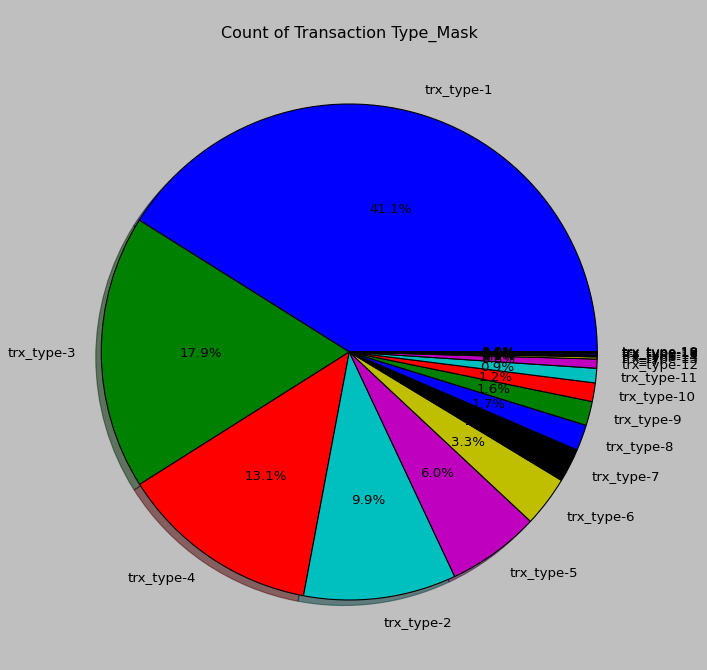

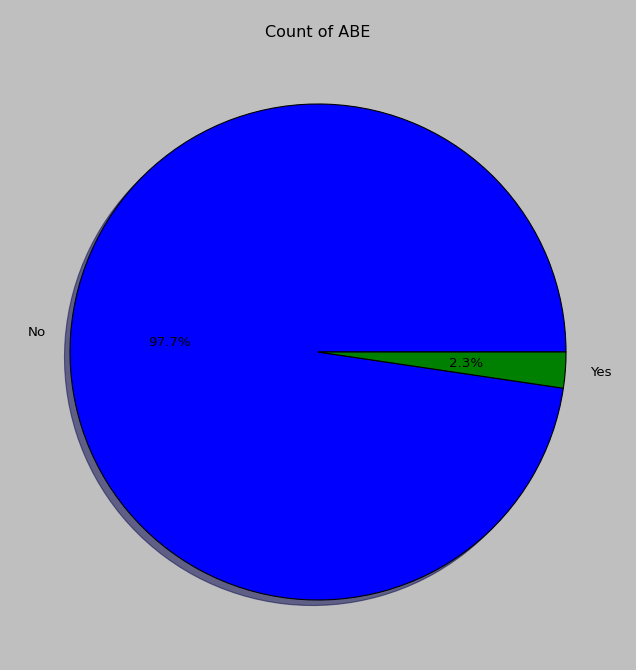

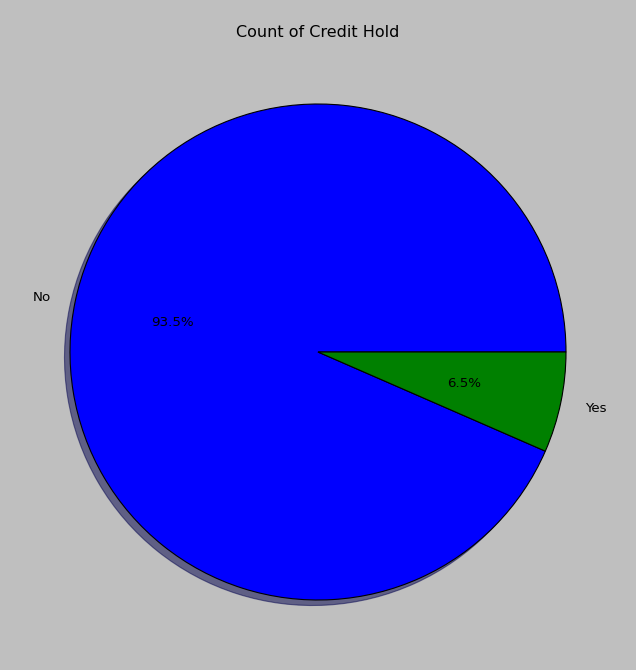

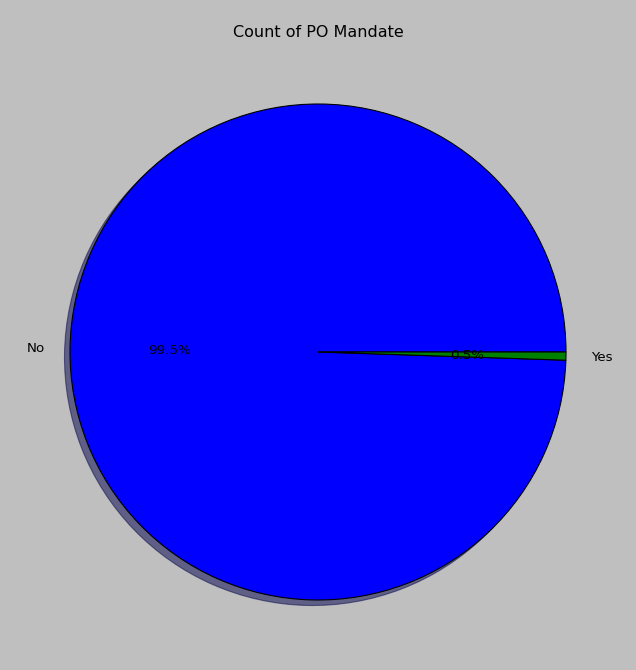

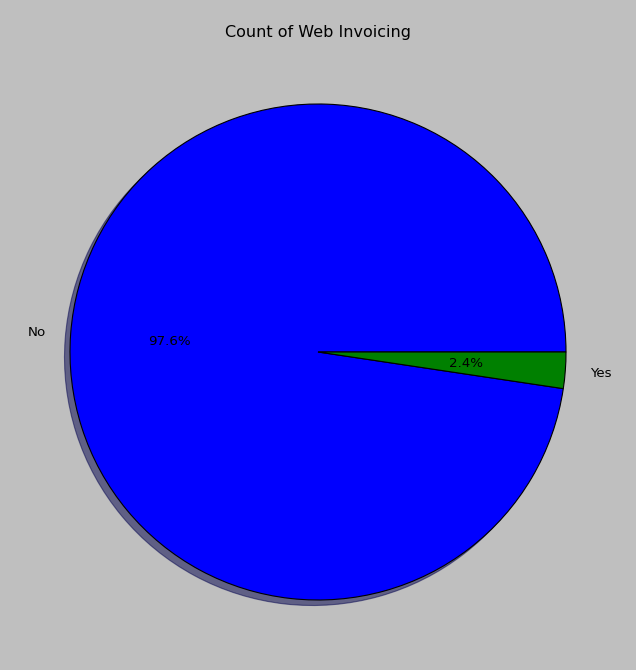

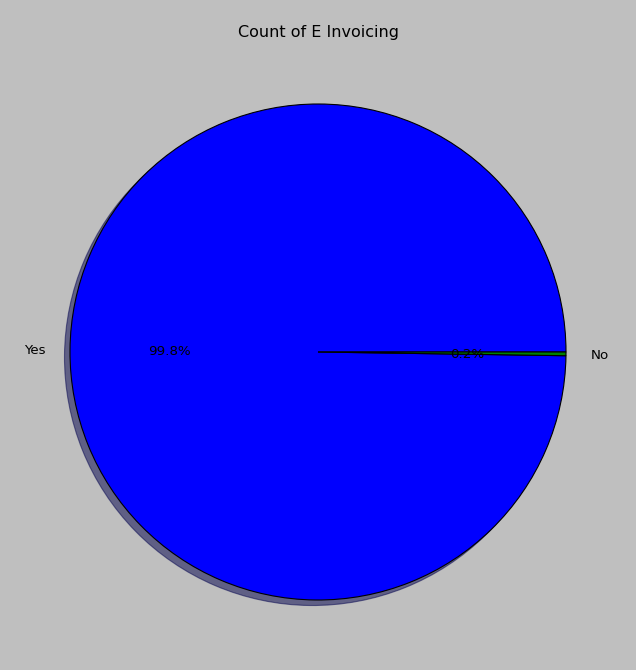

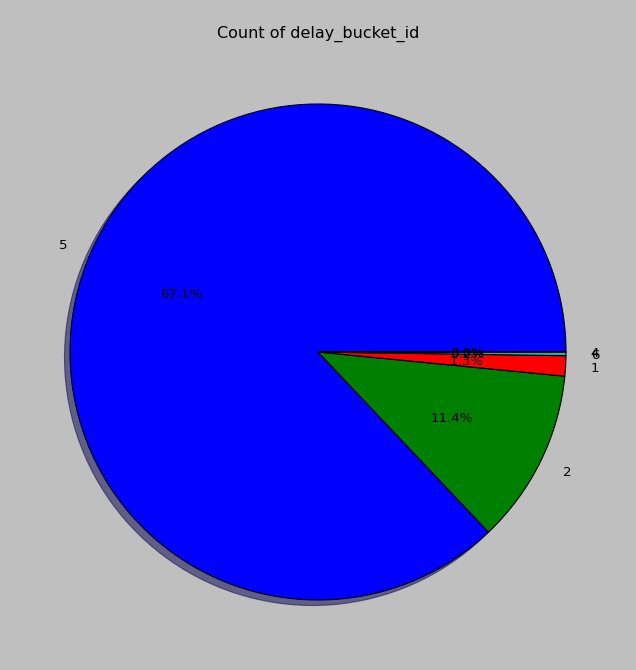

In [ ]:
for col in ['Transaction Type_Mask','ABE','Credit Hold', 'PO Mandate','Web Invoicing','E Invoicing','delay_bucket_id']:
    plt.style.use('classic')
    fig,ax = plt.subplots(figsize=(10,10))
    plt.pie(df[col].value_counts(),labels=df[col].unique(),shadow=True,autopct='%1.1f%%')
    plt.title('\nCount of {}'.format(col))
    plt.show()

In [ ]:
#for col in list(set(df.columns) - set(['DELAY BUCKET(DAYS)'])):
    #sns.distplot(df[col],color='maroon')
    #plt.show()

# **Modeling**

As this is a classification and regression model we will use the following models -





*   Logistic Regression for Paid_15 label
*   XGBoost Classification for Paid_15 label
*   XGBoost Classification for DPLC label
*   XGBoost Regression for DPLC label
*   Random Forest Classifier for Paid label
*   Random Forest Classifier for DPLC label
*   Random Forest Regressor for DPLC label
*   Neural Network
*   K-Negihbours
*   Linear SVC

Paid_15 is to classify if the invoice will be paid within 15 days after due date or not

DPLC is to predict the delay in payment in weeks












# Logistic Regression for Paid Model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_Paid, Y_Paid_15, test_size=0.33, random_state=42)
log_classification_paid_encoding = one_hot_encoder.fit(X_train)
X_train = one_hot_encoder.transform(X_train)
X_test = one_hot_encoder.transform(X_test)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(max_iter = 300)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print("Accuracy Score:")
print(np.sqrt(metrics.accuracy_score(y_test,y_pred)))
print("F1 Score:")
print(metrics.f1_score(y_test,y_pred,average='micro'))

Accuracy Score:
0.6862672065298501
F1 Score:
0.4709626787582839


Confusion Matrix for Logistic Regression

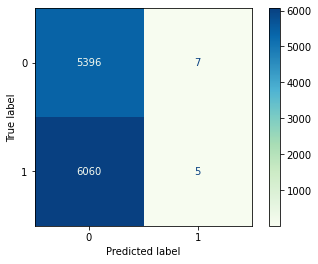

In [ ]:
from sklearn import metrics

#confusion matrix
confusion_matrix = metrics.plot_confusion_matrix(reg, X_test, y_test, cmap = "GnBu")
print(confusion_matrix)

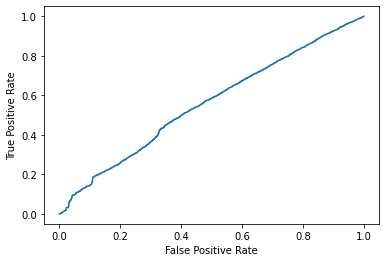

In [ ]:
#define metrics
y_pred_proba = reg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC Curve for Logistic Regression

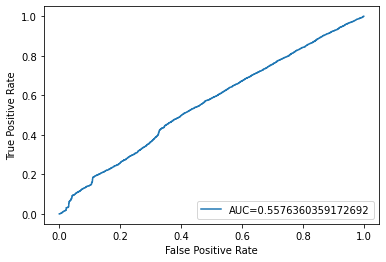

In [ ]:
#define metrics
y_pred_proba = reg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# XGBoost Classification Model - Paid Label

In [34]:
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X_Paid, Y_Paid_15, test_size=0.2, random_state=1)
xgb_classification_paid_encoding = one_hot_encoder.fit(X_train)
X_train = one_hot_encoder.transform(X_train)
X_test = one_hot_encoder.transform(X_test)
#xgb_model_Paid = xgb.XGBClassifier(n_estimators=100,max_depth=15)
#xgb_model_Paid = xgb.XGBClassifier(n_estimators=100,max_depth=15,eta=0.01)
xgb_model_Paid = xgb.XGBClassifier(n_estimators=100,max_depth=15,eta=0.1)
xgb_model_Paid.fit(X_train,y_train)
y_pred = xgb_model_Paid.predict(X_test)

print("Accuracy Score:")
print(np.sqrt(metrics.accuracy_score(y_test,y_pred)))
print("F1 Score:")
print(metrics.f1_score(y_test,y_pred,average='micro'))

Accuracy Score:
0.8157619909626095
F1 Score:
0.6654676258992805


In [25]:
print(xgb_model_Paid.feature_importances_)

[0.00446415 0.01014086 0.         0.00740837 0.01162265 0.02822358
 0.02280205 0.02122223 0.         0.06804706 0.00834086 0.0080154
 0.01352233 0.01209395 0.007019   0.00898127 0.03724981 0.01537665
 0.01419975 0.0105577  0.23365983 0.01060435 0.01545846 0.00794449
 0.         0.00988129 0.         0.04354144 0.         0.00665998
 0.         0.02279477 0.         0.01547148 0.         0.10421085
 0.01093878 0.         0.01694777 0.01214101 0.00766256 0.14019302
 0.         0.00718717 0.0090442  0.00841071 0.00796016 0.        ]


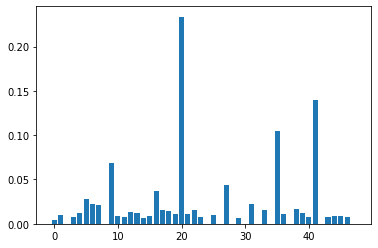

In [26]:
# plot
from matplotlib import pyplot
pyplot.bar(range(len(xgb_model_Paid.feature_importances_)), xgb_model_Paid.feature_importances_)
pyplot.show()

In [27]:
print("X_train size ===>", X_train.shape)
print("y_train size ===>", y_train.shape)
print("X_test size ===>", X_test.shape)
print("y_test size ===>", y_test.shape)

X_train size ===> (27800, 48)
y_train size ===> (27800, 1)
X_test size ===> (6950, 48)
y_test size ===> (6950, 1)


Confusion Matrix for XGBoost Classifier (Paid Label)

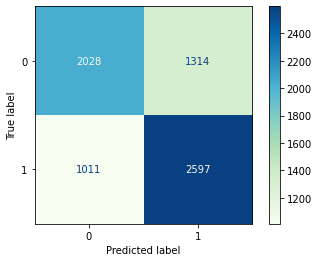

In [28]:
from sklearn import metrics

#confusion matrix
confusion_matrix = metrics.plot_confusion_matrix(xgb_model_Paid, X_test, y_test, cmap = "GnBu")
print(confusion_matrix)

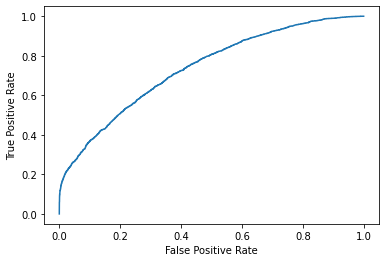

In [29]:
#define metrics
y_pred_proba = xgb_model_Paid.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC Curve for XGBoost Classifier (Paid label)

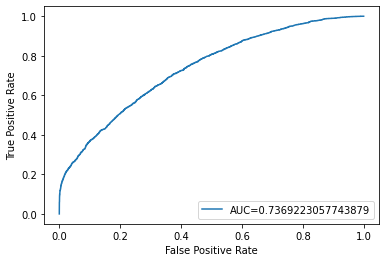

In [30]:
#define metrics
y_pred_proba = xgb_model_Paid.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [31]:
# Finding precision
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, y_pred)

0.6640245461518793

In [32]:
# Finding recall
from sklearn.metrics import precision_score, recall_score
recall_score(y_test, y_pred, average=None)

array([0.60682226, 0.71978936])

In [33]:
# To compute the F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.690783348849581

In [ ]:
y_pred = label_encoder.inverse_transform(y_pred)
y_pred

array(['No', 'No', 'No', ..., 'No', 'Yes', 'No'], dtype=object)

# XBoost Classification Model - DPLC Label

In [ ]:
#import xgboost as xgb
#X_train, X_test, y_train, y_test = train_test_split(X_DPLC, Y_DPLC, test_size=0.1, random_state=1)
#one_hot_encoder.fit(X_train)
#X_train = one_hot_encoder.transform(X_train)
#X_test = one_hot_encoder.transform(X_test)
#xgb_model_dplc_classification = xgb.XGBClassifier(n_estimators=1000,max_depth=15)
#xgb_model_dplc_classification.fit(X_train,y_train)
#y_pred = xgb_model_dplc_classification.predict(X_test)

#print("Accuracy Score:")
#print(np.sqrt(metrics.accuracy_score(y_test,y_pred)))
#print("F1 Score:")
#print(metrics.f1_score(y_test,y_pred,average='micro'))

Accuracy Score:
0.5899028292738966
F1 Score:
0.34798534798534797


In [ ]:
y_pred

array([10,  3,  2, ..., 10,  5, 10])

# XBoost Regression Model - DPLC Label

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_DPLC, Y_DPLC, test_size=0.1, random_state=1)
xgb_regression_paid_encoding = one_hot_encoder.fit(X_train)
X_train = one_hot_encoder.transform(X_train)
X_test = one_hot_encoder.transform(X_test)
xgb_model_dplc = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model_dplc.fit(X_train,y_train)
y_pred = xgb_model_dplc.predict(X_test)

print("R2 Score:")
print(metrics.r2_score(y_test,y_pred))
print("RMSE:")
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

R2 Score:
0.12855799913341737
RMSE:
2.833783362344222


In [ ]:
y_pred

array([6.874734 , 5.3527584, 5.0163875, ..., 7.830971 , 5.1900516,
       6.0420275], dtype=float32)

# Scaling values in each column

In [ ]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X_Paid, Y_Paid_15, test_size=0.1, random_state=1)
rf_classification_paid_encoding = one_hot_encoder.fit(X_train)
X_train = one_hot_encoder.transform(X_train)
X_test = one_hot_encoder.transform(X_test)
# Feature Scaling
rf_classification_scaler = StandardScaler()
X_train = rf_classification_scaler.fit_transform(X_train)
X_test = rf_classification_scaler.transform(X_test)

#Random Forest Classifier - Paid Label

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#Fitting Random Forest Classification to the Training set
rfclassifier_paid = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 10,max_depth=12,max_features=None)
rfclassifier_paid.fit(X_train, y_train)
# Predicting the Test set results
y_pred = rfclassifier_paid.predict(X_test)
print("Accuracy Score:")
print(np.sqrt(metrics.accuracy_score(y_test,y_pred)))
print("F1 Score:")
print(metrics.f1_score(y_test,y_pred,average='micro'))

Accuracy Score:
0.8073404245738468
F1 Score:
0.6517985611510791


Confusion Matrix for Random Forest Classifier (Paid label)

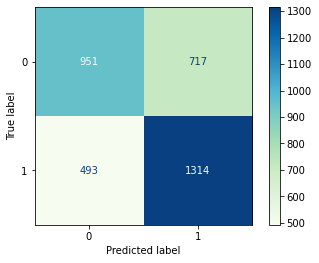

In [ ]:
from sklearn import metrics

#confusion matrix
confusion_matrix = metrics.plot_confusion_matrix(rfclassifier_paid, X_test, y_test, cmap = "GnBu")
print(confusion_matrix)

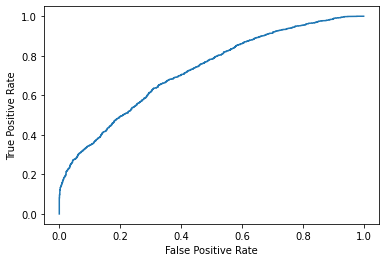

In [ ]:
#define metrics
y_pred_proba = rfclassifier_paid.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC Curve for Random Forest Classifier (Paid label)

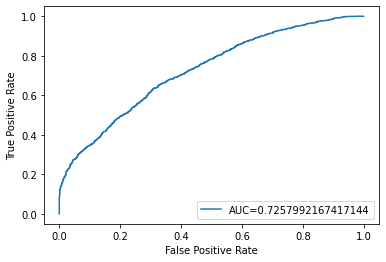

In [ ]:
#define metrics
y_pred_proba = rfclassifier_paid.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
# Finding precision
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, y_pred)

0.6469719350073855

In [ ]:
# Finding recall
from sklearn.metrics import precision_score, recall_score
recall_score(y_test, y_pred, average=None)

array([0.57014388, 0.72717211])

In [ ]:
# To compute the F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.6847316310578425

# Hyper Parameter Tuning for Random Forest

In [ ]:
from sklearn.metrics import roc_curve, auc

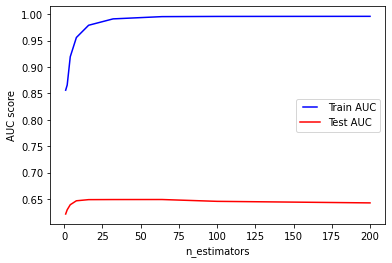

In [ ]:
rf = RandomForestClassifier()
n_estimators = [1,2,4,8,16,32,64,100,200]
train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

# Random Forest Classifier - DPLC Label

In [ ]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X_DPLC, Y_DPLC, test_size=0.1, random_state=1)
rf_regression_dplc_encoding = one_hot_encoder.fit(X_train)
X_train = one_hot_encoder.transform(X_train)
X_test = one_hot_encoder.transform(X_test)
# Feature Scaling
rf_regression_scaler = StandardScaler()
X_train = rf_regression_scaler.fit_transform(X_train)
X_test = rf_regression_scaler.transform(X_test)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# #Fitting Random Forest Classification to the Training set
rfclassifier_dplc = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 10,max_depth=12,max_features=None)
rfclassifier_dplc.fit(X_train, y_train)
# # Predicting the Test set results
y_pred = rfclassifier_dplc.predict(X_test)
print("Accuracy Score:")
print(metrics.accuracy_score(y_test,y_pred))
print("F1 Score:")
print(metrics.f1_score(y_test,y_pred,average='micro'))

Accuracy Score:
0.38583638583638585
F1 Score:
0.38583638583638585


# Random Forest Regressor - DPLC Label

In [ ]:
from sklearn.ensemble import RandomForestRegressor
#Fitting Random Forest Classification to the Training set
rfregressor_dplc = RandomForestRegressor(n_estimators = 1000, random_state = 10,max_depth=12,max_features=None)
rfregressor_dplc.fit(X_train, y_train)
# Predicting the Test set results
y_pred = rfregressor_dplc.predict(X_test)
print("R2 Score:")
print(metrics.r2_score(y_test,y_pred))
print("RMSE:")
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

R2 Score:
0.17350136810298367
RMSE:
2.7597419281295874


#Neural Network Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(X_DPLC, Y_DPLC, test_size=0.1, random_state=1)
X_train = one_hot_encoder.transform(X_train)
X_test = one_hot_encoder.transform(X_test)
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy Score:")
print(np.sqrt(metrics.accuracy_score(y_test,y_pred)))
print("F1 Score:")
metrics.f1_score(y_test,y_pred,average='micro')

Accuracy Score:
0.3827795011754764
F1 Score:


0.14652014652014653

# K Neighbors Classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_DPLC, Y_DPLC, test_size=0.1, random_state=1)
from sklearn.neighbors import KNeighborsClassifier
X_train = one_hot_encoder.transform(X_train)
X_test = one_hot_encoder.transform(X_test)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print("Accuracy Score:")
print(np.sqrt(metrics.accuracy_score(y_test,y_pred)))
print("F1 Score:")
metrics.f1_score(y_test,y_pred,average='micro')

Accuracy Score:
0.45020684433513747
F1 Score:


0.2026862026862027

#Linear SVC

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X_DPLC, Y_DPLC, test_size=0.1, random_state=1)
X_train = one_hot_encoder.transform(X_train)
X_test = one_hot_encoder.transform(X_test)
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy Score:")
print(np.sqrt(metrics.accuracy_score(y_test,y_pred)))
print("F1 Score:")
metrics.f1_score(y_test,y_pred,average='micro')

Accuracy Score:
0.5502802039037047
F1 Score:


0.3028083028083028

# Inference Mode 

In [ ]:
#read historical data
df = pd.read_excel('New_Records.xlsx')
temp_df = df.copy()

df['delay']=(df['Due Date']-df['Transaction Date']).dt.days

df["Transaction Date_day"] = df["Transaction Date"].dt.day
df["Transaction Date_month"] = df["Transaction Date"].dt.month

df["Due Date_day"] = df["Due Date"].dt.day
df["Due Date_month"] = df["Due Date"].dt.month

# dropping unwanted columns
cols_to_del_final_output = ['Quarter','Concat','Transaction Date_Date', 'Batch Source_Masked','Transaction Date_Mon','Transaction Date_Day','Due_Date_Date','Due_Date_Month','Due_Date_Day','Transaction Type_Mask', 'ABE', 'Credit Hold', 'PO Mandate','Web Invoicing', 'E Invoicing', 'DPLC', 'USD_AMT', 'buffer_days']
#cols_to_del_final_output = ['Quarter','Concat','Transaction Date_Date', 'Batch Source_Masked','Due_Date_Date','Transaction Type_Mask', 'ABE', 'Credit Hold', 'PO Mandate','Web Invoicing', 'E Invoicing', 'DPLC', 'USD_AMT', 'buffer_days']
temp_df.drop(columns=cols_to_del_final_output,inplace=True)

# dropping unwanted columns
cols_to_del = ['FY_Quarter','Quarter','Transaction Number','Transaction Date','Concat','Transaction Date_Date','Transaction Date_Mon','Transaction Date_Day','Due Date','Due_Date_Date','Due_Date_Month','Due_Date_Day','Paid_15_Actual','DPLC_Week_Actual']
#cols_to_del = ['FY_Quarter','Quarter','Transaction Number','Transaction Date','Concat','Transaction Date_Date','Due Date','Due_Date_Date','Paid_15_Actual','DPLC_Week_Actual']
df.drop(columns=cols_to_del,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Transaction Type_Mask   1000 non-null   object 
 1   Batch Source_Masked     1000 non-null   object 
 2   ABE                     1000 non-null   object 
 3   Credit Hold             1000 non-null   object 
 4   PO Mandate              1000 non-null   object 
 5   Web Invoicing           1000 non-null   object 
 6   E Invoicing             1000 non-null   object 
 7   DPLC                    1000 non-null   int64  
 8   USD_AMT                 1000 non-null   float64
 9   buffer_days             1000 non-null   int64  
 10  delay                   1000 non-null   int64  
 11  Transaction Date_day    1000 non-null   int64  
 12  Transaction Date_month  1000 non-null   int64  
 13  Due Date_day            1000 non-null   int64  
 14  Due Date_month          1000 non-null   i

In [ ]:
gc.collect()
df = df.reset_index(drop=True)
df['DELAY BUCKET(DAYS)']= pd.Series([bucketization(x=df['delay'][i])  for i in range(len(df))])
bucket_mapper = {'(< 0) Days':0,'(0-15) Days':1,'(16-30) Days':2,'(31-45) Days':4,'(45-60) Days':5,'(> 60) Days':6}
df['delay_bucket_id'] = df['DELAY BUCKET(DAYS)'].map(bucket_mapper)
df.columns

Index(['Transaction Type_Mask', 'Batch Source_Masked', 'ABE', 'Credit Hold',
       'PO Mandate', 'Web Invoicing', 'E Invoicing', 'DPLC', 'USD_AMT',
       'buffer_days', 'delay', 'Transaction Date_day',
       'Transaction Date_month', 'Due Date_day', 'Due Date_month',
       'DELAY BUCKET(DAYS)', 'delay_bucket_id'],
      dtype='object')

In [ ]:
xgb_classifier_encoding = xgb_classification_paid_encoding.transform(df)
xgb_paid_predictions = xgb_model_Paid.predict(xgb_classifier_encoding)
xgb_paid_predictions = label_encoder.inverse_transform(xgb_paid_predictions)
df['Paid_15'] = pd.Series(xgb_paid_predictions)
filtered_df_paid_no = df[df['Paid_15']=='No']
filtered_df_paid_no

,Transaction Type_Mask,Batch Source_Masked,ABE,Credit Hold,PO Mandate,Web Invoicing,E Invoicing,DPLC,USD_AMT,buffer_days,delay,Transaction Date_day,Transaction Date_month,Due Date_day,Due Date_month,DELAY BUCKET(DAYS),delay_bucket_id,Paid_15
0,trx_type-13,batch_source-3,No,No,No,No,Yes,16,2600.478478,30,30,4,5,3,6,(16-30) Days,2,No
1,trx_type-2,batch_source-2,No,No,No,No,Yes,16,39824.038547,30,30,4,5,3,6,(16-30) Days,2,No
2,trx_type-4,batch_source-5,No,No,No,No,Yes,16,3707.392360,30,30,5,5,4,6,(16-30) Days,2,No
3,trx_type-2,batch_source-2,No,No,No,No,Yes,17,5008.715423,30,30,9,5,8,6,(16-30) Days,2,No
5,trx_type-9,batch_source-3,No,No,No,No,Yes,17,33306.068637,30,30,11,5,10,6,(16-30) Days,2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,trx_type-2,batch_source-2,No,No,No,No,Yes,8,18728.279568,30,30,11,5,10,6,(16-30) Days,2,No
990,trx_type-3,batch_source-2,No,No,No,No,Yes,11,2878.782403,30,30,11,5,10,6,(16-30) Days,2,No
991,trx_type-4,batch_source-5,No,No,No,No,Yes,0,25679.068215,30,30,12,5,11,6,(16-30) Days,2,No
992,trx_type-4,batch_source-5,No,No,No,No,Yes,15,33308.156513,30,30,12,5,11,6,(16-30) Days,2,No


In [ ]:
temp = filtered_df_paid_no['Paid_15']
filtered_df_paid_no.drop(columns=['Paid_15'],inplace=True)
xgb_regressor_encoding = xgb_regression_paid_encoding.transform(filtered_df_paid_no)
xbg_dplc_predictions = xgb_model_dplc.predict(xgb_regressor_encoding)
xbg_dplc_predictions = np.round_(xbg_dplc_predictions, decimals = 0, out = None)
filtered_df_paid_no['Paid_15'] = temp
filtered_df_paid_no['Delay in Weeks'] = xbg_dplc_predictions
filtered_df_paid_no

,Transaction Type_Mask,Batch Source_Masked,ABE,Credit Hold,PO Mandate,Web Invoicing,E Invoicing,DPLC,USD_AMT,buffer_days,delay,Transaction Date_day,Transaction Date_month,Due Date_day,Due Date_month,DELAY BUCKET(DAYS),delay_bucket_id,Paid_15,Delay in Weeks
0,trx_type-13,batch_source-3,No,No,No,No,Yes,16,2600.478478,30,30,4,5,3,6,(16-30) Days,2,No,6.0
1,trx_type-2,batch_source-2,No,No,No,No,Yes,16,39824.038547,30,30,4,5,3,6,(16-30) Days,2,No,5.0
2,trx_type-4,batch_source-5,No,No,No,No,Yes,16,3707.392360,30,30,5,5,4,6,(16-30) Days,2,No,7.0
3,trx_type-2,batch_source-2,No,No,No,No,Yes,17,5008.715423,30,30,9,5,8,6,(16-30) Days,2,No,6.0
5,trx_type-9,batch_source-3,No,No,No,No,Yes,17,33306.068637,30,30,11,5,10,6,(16-30) Days,2,No,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,trx_type-2,batch_source-2,No,No,No,No,Yes,8,18728.279568,30,30,11,5,10,6,(16-30) Days,2,No,6.0
990,trx_type-3,batch_source-2,No,No,No,No,Yes,11,2878.782403,30,30,11,5,10,6,(16-30) Days,2,No,6.0
991,trx_type-4,batch_source-5,No,No,No,No,Yes,0,25679.068215,30,30,12,5,11,6,(16-30) Days,2,No,7.0
992,trx_type-4,batch_source-5,No,No,No,No,Yes,15,33308.156513,30,30,12,5,11,6,(16-30) Days,2,No,7.0


In [ ]:
final_output_df_xgb = filtered_df_paid_no.join(temp_df) 
final_output_df_xgb

,Transaction Type_Mask,Batch Source_Masked,ABE,Credit Hold,PO Mandate,Web Invoicing,E Invoicing,DPLC,USD_AMT,buffer_days,...,DELAY BUCKET(DAYS),delay_bucket_id,Paid_15,Delay in Weeks,FY_Quarter,Transaction Number,Transaction Date,Due Date,Paid_15_Actual,DPLC_Week_Actual
0,trx_type-13,batch_source-3,No,No,No,No,Yes,16,2600.478478,30,...,(16-30) Days,2,No,6.0,Q1FY19,Trx_1012,2018-05-04,2018-06-03,No,2.285714
1,trx_type-2,batch_source-2,No,No,No,No,Yes,16,39824.038547,30,...,(16-30) Days,2,No,5.0,Q1FY19,Trx_1088,2018-05-04,2018-06-03,No,2.285714
2,trx_type-4,batch_source-5,No,No,No,No,Yes,16,3707.392360,30,...,(16-30) Days,2,No,7.0,Q1FY19,Trx_1134,2018-05-05,2018-06-04,No,2.285714
3,trx_type-2,batch_source-2,No,No,No,No,Yes,17,5008.715423,30,...,(16-30) Days,2,No,6.0,Q1FY19,Trx_1279,2018-05-09,2018-06-08,No,2.428571
5,trx_type-9,batch_source-3,No,No,No,No,Yes,17,33306.068637,30,...,(16-30) Days,2,No,6.0,Q1FY19,Trx_1370,2018-05-11,2018-06-10,No,2.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,trx_type-2,batch_source-2,No,No,No,No,Yes,8,18728.279568,30,...,(16-30) Days,2,No,6.0,Q1FY19,Trx_1386,2018-05-11,2018-06-10,Yes,1.142857
990,trx_type-3,batch_source-2,No,No,No,No,Yes,11,2878.782403,30,...,(16-30) Days,2,No,6.0,Q1FY19,Trx_1399,2018-05-11,2018-06-10,Yes,1.571429
991,trx_type-4,batch_source-5,No,No,No,No,Yes,0,25679.068215,30,...,(16-30) Days,2,No,7.0,Q1FY19,Trx_1400,2018-05-12,2018-06-11,Yes,0.000000
992,trx_type-4,batch_source-5,No,No,No,No,Yes,15,33308.156513,30,...,(16-30) Days,2,No,7.0,Q1FY19,Trx_1401,2018-05-12,2018-06-11,Yes,2.142857


In [ ]:
final_output_df_xgb.to_excel('xgbResults.xlsx',index=False)

In [ ]:
df.drop(columns=['Paid_15'],inplace=True)
rf_classifier_encoding = rf_classification_paid_encoding.transform(df)
rf_classifier_encoding = rf_classification_scaler.transform(rf_classifier_encoding)
rf_paid_predictions = rfclassifier_paid.predict(rf_classifier_encoding)
rf_paid_predictions = label_encoder.inverse_transform(rf_paid_predictions)
df['Paid_15'] = pd.Series(rf_paid_predictions)
filtered_df_paid_no = df[df['Paid_15']=='No']
filtered_df_paid_no

,Transaction Type_Mask,Batch Source_Masked,ABE,Credit Hold,PO Mandate,Web Invoicing,E Invoicing,DPLC,USD_AMT,buffer_days,delay,Transaction Date_day,Transaction Date_month,Due Date_day,Due Date_month,DELAY BUCKET(DAYS),delay_bucket_id,Paid_15
0,trx_type-13,batch_source-3,No,No,No,No,Yes,16,2600.478478,30,30,4,5,3,6,(16-30) Days,2,No
1,trx_type-2,batch_source-2,No,No,No,No,Yes,16,39824.038547,30,30,4,5,3,6,(16-30) Days,2,No
2,trx_type-4,batch_source-5,No,No,No,No,Yes,16,3707.392360,30,30,5,5,4,6,(16-30) Days,2,No
3,trx_type-2,batch_source-2,No,No,No,No,Yes,17,5008.715423,30,30,9,5,8,6,(16-30) Days,2,No
4,trx_type-2,batch_source-2,No,No,No,No,Yes,17,977.123893,30,30,9,5,8,6,(16-30) Days,2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,trx_type-4,batch_source-5,No,Yes,No,No,Yes,10,6347.925631,30,30,11,5,10,6,(16-30) Days,2,No
974,trx_type-4,batch_source-5,No,No,No,No,Yes,0,41757.532162,30,30,11,5,10,6,(16-30) Days,2,No
991,trx_type-4,batch_source-5,No,No,No,No,Yes,0,25679.068215,30,30,12,5,11,6,(16-30) Days,2,No
992,trx_type-4,batch_source-5,No,No,No,No,Yes,15,33308.156513,30,30,12,5,11,6,(16-30) Days,2,No


In [ ]:
temp = filtered_df_paid_no['Paid_15']
filtered_df_paid_no.drop(columns=['Paid_15'],inplace=True)
rf_regressor_encoding = rf_regression_dplc_encoding.transform(filtered_df_paid_no)
rf_regressor_encoding = rf_regression_scaler.transform(rf_regressor_encoding)
rf_dplc_predictions = rfregressor_dplc.predict(rf_regressor_encoding)
rf_dplc_predictions = np.round_(rf_dplc_predictions, decimals = 0, out = None)
filtered_df_paid_no['Paid_15'] = temp
filtered_df_paid_no['Delay in Weeks'] = rf_dplc_predictions
filtered_df_paid_no

,Transaction Type_Mask,Batch Source_Masked,ABE,Credit Hold,PO Mandate,Web Invoicing,E Invoicing,DPLC,USD_AMT,buffer_days,delay,Transaction Date_day,Transaction Date_month,Due Date_day,Due Date_month,DELAY BUCKET(DAYS),delay_bucket_id,Paid_15,Delay in Weeks
0,trx_type-13,batch_source-3,No,No,No,No,Yes,16,2600.478478,30,30,4,5,3,6,(16-30) Days,2,No,6.0
1,trx_type-2,batch_source-2,No,No,No,No,Yes,16,39824.038547,30,30,4,5,3,6,(16-30) Days,2,No,5.0
2,trx_type-4,batch_source-5,No,No,No,No,Yes,16,3707.392360,30,30,5,5,4,6,(16-30) Days,2,No,6.0
3,trx_type-2,batch_source-2,No,No,No,No,Yes,17,5008.715423,30,30,9,5,8,6,(16-30) Days,2,No,7.0
4,trx_type-2,batch_source-2,No,No,No,No,Yes,17,977.123893,30,30,9,5,8,6,(16-30) Days,2,No,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,trx_type-4,batch_source-5,No,Yes,No,No,Yes,10,6347.925631,30,30,11,5,10,6,(16-30) Days,2,No,7.0
974,trx_type-4,batch_source-5,No,No,No,No,Yes,0,41757.532162,30,30,11,5,10,6,(16-30) Days,2,No,7.0
991,trx_type-4,batch_source-5,No,No,No,No,Yes,0,25679.068215,30,30,12,5,11,6,(16-30) Days,2,No,7.0
992,trx_type-4,batch_source-5,No,No,No,No,Yes,15,33308.156513,30,30,12,5,11,6,(16-30) Days,2,No,7.0


In [ ]:
final_output_df = filtered_df_paid_no.join(temp_df) 
final_output_df

,Transaction Type_Mask,Batch Source_Masked,ABE,Credit Hold,PO Mandate,Web Invoicing,E Invoicing,DPLC,USD_AMT,buffer_days,...,DELAY BUCKET(DAYS),delay_bucket_id,Paid_15,Delay in Weeks,FY_Quarter,Transaction Number,Transaction Date,Due Date,Paid_15_Actual,DPLC_Week_Actual
0,trx_type-13,batch_source-3,No,No,No,No,Yes,16,2600.478478,30,...,(16-30) Days,2,No,6.0,Q1FY19,Trx_1012,2018-05-04,2018-06-03,No,2.285714
1,trx_type-2,batch_source-2,No,No,No,No,Yes,16,39824.038547,30,...,(16-30) Days,2,No,5.0,Q1FY19,Trx_1088,2018-05-04,2018-06-03,No,2.285714
2,trx_type-4,batch_source-5,No,No,No,No,Yes,16,3707.392360,30,...,(16-30) Days,2,No,6.0,Q1FY19,Trx_1134,2018-05-05,2018-06-04,No,2.285714
3,trx_type-2,batch_source-2,No,No,No,No,Yes,17,5008.715423,30,...,(16-30) Days,2,No,7.0,Q1FY19,Trx_1279,2018-05-09,2018-06-08,No,2.428571
4,trx_type-2,batch_source-2,No,No,No,No,Yes,17,977.123893,30,...,(16-30) Days,2,No,6.0,Q1FY19,Trx_1303,2018-05-09,2018-06-08,No,2.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,trx_type-4,batch_source-5,No,Yes,No,No,Yes,10,6347.925631,30,...,(16-30) Days,2,No,7.0,Q1FY19,Trx_1364,2018-05-11,2018-06-10,Yes,1.428571
974,trx_type-4,batch_source-5,No,No,No,No,Yes,0,41757.532162,30,...,(16-30) Days,2,No,7.0,Q1FY19,Trx_1365,2018-05-11,2018-06-10,Yes,0.000000
991,trx_type-4,batch_source-5,No,No,No,No,Yes,0,25679.068215,30,...,(16-30) Days,2,No,7.0,Q1FY19,Trx_1400,2018-05-12,2018-06-11,Yes,0.000000
992,trx_type-4,batch_source-5,No,No,No,No,Yes,15,33308.156513,30,...,(16-30) Days,2,No,7.0,Q1FY19,Trx_1401,2018-05-12,2018-06-11,Yes,2.142857


In [ ]:
final_output_df.to_excel('RFResults.xlsx',index=False)